In [2]:
from jax import numpy as jnp
import pickle

In [3]:
# load data
with open("../../results/cost.pkl", "rb") as f:
    y = pickle.load(f)
with open("../../results/a_sampled.pkl", "rb") as f:
    x = pickle.load(f)
with open("../../results/a_mean.pkl", "rb") as f:
    x_mean = pickle.load(f)
with open("../../results/a_cov.pkl", "rb") as f:
    x_cov = pickle.load(f)

2024-01-21 14:06:07.251794: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 12569739264
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# sampled x, shape (1024, 32)
x = x[..., 0]
# sampled y, shape (1024,)

In [5]:
import jaxopt
# solve the optimization problem
# min_{A,b,c} sum_i (y_i - x_i^T A x_i - b^T x_i - c)^2

# define the objective function
def f(params):
    A, b, c = params
    return jnp.sum((y - jnp.sum(x * (A @ x), axis=-1) - b @ x - c)**2)

# define the gradient of the objective function
def f_grad(params):
    A, b, c = params
    grad_A = -2 * jnp.sum(x[..., None] * x[:, None, :] * (y - jnp.sum(x * (A @ x), axis=-1) - b @ x - c)[:, None, None], axis=0)
    grad_b = -2 * jnp.sum(x * (y - jnp.sum(x * (A @ x), axis=-1) - b @ x - c)[:, None], axis=0)
    grad_c = -2 * jnp.sum(y - jnp.sum(x * (A @ x), axis=-1) - b @ x - c)
    return (grad_A, grad_b, grad_c)

# define the hessian of the objective function
def f_hessian(params):
    A, b, c = params
    hess_A = 2 * jnp.sum(x[..., None, None] * x[:, None, :, None] * x[:, None, None, :] * x[:, None, None, None] * (A @ x)[:, None, None, None] * (A @ x)[:, None, None, None], axis=0)
    hess_b = 2 * jnp.sum(x[..., None, None] * x[:, None, :, None] * x[:, None, None, None] * (A @ x)[:, None, None, None], axis=0)
    hess_c = 2 * jnp.sum(x[..., None, None] * x[:, None, :, None] * (A @ x)[:, None, None, None], axis=0)
    return (hess_A, hess_b, hess_c)

# define the initial guess
A0 = jnp.zeros((32, 32))
b0 = jnp.zeros((32,))
c0 = 0.

In [6]:
# NOTE: A = 1/2 Hessian

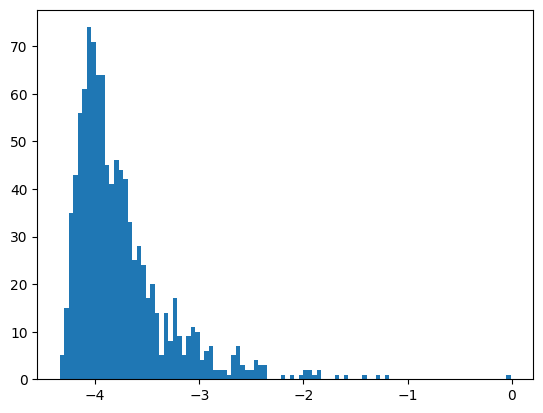

In [7]:
# plot y distribution

from matplotlib import pyplot as plt

lam = 0.01

y_topk = jnp.sort(y)[::-1][:int(len(y) * 1.0)]

plt.hist(y_topk, bins=100);